In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import polars as pl
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Dict, List, Tuple

In [2]:
# Constants
BATCH_SIZE = 64
EMB_DIM = 128
HID_DIM = 258
N_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 10
FRAC = 0.2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load parquet file
local_path = "../data/output/processed.parquet"
colab_path = "../content/processed.parquet"
kaggle_path= "/kaggle/input/it-en-translation/processed.parquet"
loaded_data = pl.read_parquet(kaggle_path)
print("Data loaded successfully")
loaded_data.head()

Data loaded successfully


it,en
list[str],list[str]
"[""grazie"", ""amico""]","[""thank"", ""buddy""]"
"[""di il""]","[""say""]"
"[""trifosfare"", ""sodio"", … ""sodio""]","[""sodium"", ""triphosphate"", … ""tripolyphosphate""]"
"[""invero"", ""avidare"", … ""ricchezzo""]","[""surely"", ""ardent"", … ""wealth""]"
"[""allegare""]","[""annex""]"


In [5]:
input_data = loaded_data.sample(fraction = FRAC)

In [6]:
input_data.describe()

statistic,it,en
str,f64,f64
"""count""",192008.0,192008.0
"""null_count""",0.0,0.0
"""mean""",null,null
"""std""",null,null
"""min""",null,null
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""",null,null


In [7]:
from collections import defaultdict

def build_vocab(tokens):
    vocab = defaultdict(lambda: len(vocab))  # Assign unique indices
    vocab["<pad>"]  # Reserve 0 for padding
    for token_list in tokens:
        for token in token_list:
            _ = vocab[token]
    return dict(vocab)

def preprocess_data(df):
    it_vocab = build_vocab(df["it"])
    en_vocab = build_vocab(df["en"])
    
    it_indices = [
        torch.tensor([it_vocab[token] for token in tokens], dtype=torch.long)
        for tokens in df["it"]
    ]
    en_indices = [
        torch.tensor([en_vocab[token] for token in tokens], dtype=torch.long)
        for tokens in df["en"]
    ]
    return list(zip(en_indices, it_indices)), len(it_vocab), len(en_vocab)

In [8]:
data_pairs, IT_VOCAB_SIZE, EN_VOCAB_SIZE = preprocess_data(input_data)

In [9]:
print(f"Italian Vocabulary Size: {IT_VOCAB_SIZE}")
print(f"English Vocabulary Size: {EN_VOCAB_SIZE}")

Italian Vocabulary Size: 78942
English Vocabulary Size: 52274


In [10]:
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

In [11]:
def collate_custom(batch):
    src = [pair[0] for pair in batch]
    trg = [pair[1] for pair in batch]
    src_padded = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=0)
    trg_padded = nn.utils.rnn.pad_sequence(trg, batch_first=True, padding_value=0)
    return src_padded, trg_padded

In [12]:
train_loader = DataLoader(
    TranslationDataset(data_pairs),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_custom
)

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, cell):
        trg = trg.unsqueeze(1)
        embedded = self.dropout(self.embedding(trg))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        trg_input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(trg_input, hidden, cell)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            trg_input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

In [16]:
encoder = Encoder(EN_VOCAB_SIZE, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(IT_VOCAB_SIZE, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0)  # Turn off teacher forcing
            output_dim = output.shape[-1]

            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [20]:
train_losses, eval_losses = [], []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    eval_loss = evaluate(model, train_loader, criterion)

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Eval Loss: {eval_loss:.4f}")


Epoch 1/10 - Train Loss: 8.3430 | Eval Loss: 7.9538
Epoch 2/10 - Train Loss: 7.8284 | Eval Loss: 7.5686
Epoch 3/10 - Train Loss: 7.5080 | Eval Loss: 7.2324
Epoch 4/10 - Train Loss: 7.2288 | Eval Loss: 6.9331
Epoch 5/10 - Train Loss: 6.9788 | Eval Loss: 6.6559
Epoch 6/10 - Train Loss: 6.7525 | Eval Loss: 6.3998
Epoch 7/10 - Train Loss: 6.5370 | Eval Loss: 6.1577
Epoch 8/10 - Train Loss: 6.3368 | Eval Loss: 5.9128
Epoch 9/10 - Train Loss: 6.1561 | Eval Loss: 5.7134
Epoch 10/10 - Train Loss: 5.9860 | Eval Loss: 5.5152


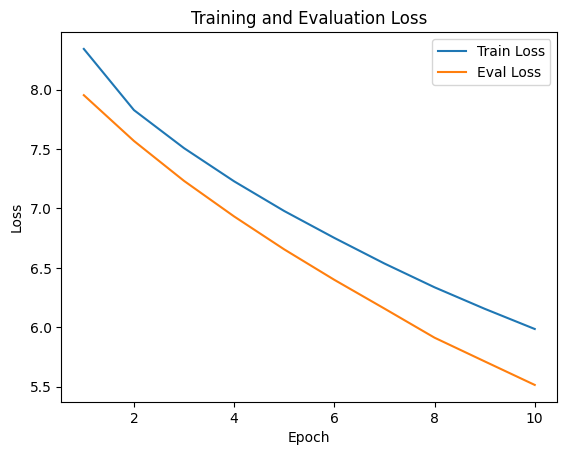

In [21]:
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), eval_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")
plt.show()
